In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # calculate distance matrix
from scipy.linalg import lu # calculate LU decomposition
from scipy.optimize import minimize # minimization of scalar function

# 1. Generate location data $X$

In [40]:
# function that makes coordincates of data points
def make_coords(N_points, xmu, xsd, ymu, ysd):
  x_coords = np.random.normal(xmu, xsd, size=N_points)
  y_coords = np.random.normal(ymu, ysd, size=N_points)
  coords = np.column_stack((x_coords, y_coords))

  return coords

In [41]:
# function that calculates distances between coordinates
def distances(coords):
  distances = cdist(coords, coords, metric='Euclidean')

  return distances

In [42]:
np.random.seed(24)

In [43]:
# set parameters
p = 1000 # dimensionaltiy

In [44]:
# get coordinates
coord = [0, 1, 0, 1] # xmu, xsd, ymu, ysd
X = make_coords(p, *coord)

In [45]:
# get distances
d = distances(X)

# 2. Covariance Matrix $\Sigma$
$$ \Sigma = Cov(Y_i, Y_j|X) = \theta_1 \exp(-\frac{1}{\theta_2} d_{ij}) \\ d_{ij} = ||X_i - X_j||$$

In [46]:
# function that makes covariance matrix Sigma
def Sigma(param, dis):
  theta1, theta2 = param[0], param[1]
  cov = theta1*np.exp((-1/theta2)*dis) # distance matrix is a square matrix
  return cov

In [47]:
# get SigmaTrue
paramTrue = [1, 1/2]
SigmaTrue = Sigma(paramTrue, d)

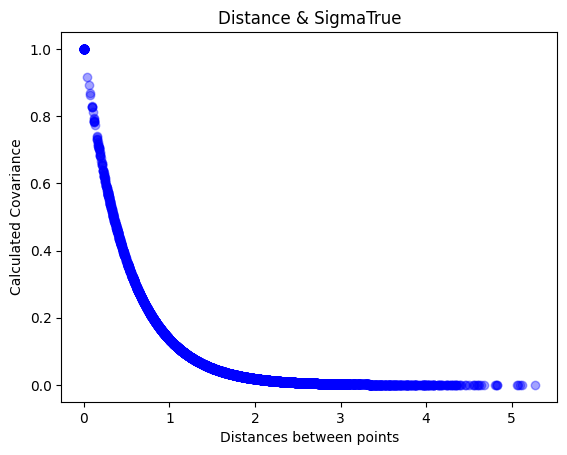

In [48]:
# plotting
d_plot = d.reshape((p*p,))
Sigma_plot = SigmaTrue.reshape((p*p,))
data = pd.DataFrame({'Distances': d_plot, 'Calculated Covariance': Sigma_plot})

plt.scatter(data['Distances'], data['Calculated Covariance'], c='blue', alpha=0.2)
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.title('Distance & SigmaTrue')
plt.show()

# 3. Generate data $Y$
$ Y = \Sigma^{1/2} \cdot U $
* $\Sigma$ is positive semi definite
* $U \sim N(0, I_p)$


Thus, $Y \sim N(0, \Sigma) $

cf. Getting $\Sigma^{1/2}$
* Choleskey factorization
    * Conditions: 1) Positive Definite, 2) Square, 3) Symmetric (No need to check condition 2 & 3 as Sigma is covariance matrix)



In [49]:
# check if SigmaTrue is positive definite
## cf. pd <-> all eigenvalues > 0
pd = np.linalg.eig(SigmaTrue)[0].min() > 0
if pd:
    SigmaHalf = np.linalg.cholesky(SigmaTrue)
    print('Covariance matrix is positive definite')
else:
    print('Covariance matrix is not positive definite')

Covariance matrix is positive definite


In [50]:
# generate y
U = np.random.normal(0, 1, p).reshape(p, 1)
Y = np.dot(SigmaHalf, U)
Y.shape # check the dimensionality of Y

(100, 1)

# 4. Parameter Estimation

$$ logL(\vec{\theta};\vec{Y}) = -\frac{1}{2} \log ( |\Sigma(\theta)|) - \frac{1}{2} \vec{Y}^T (\Sigma(\theta))^{-1} \vec{Y} $$

1. $\log ( |\Sigma(\theta)|$
* Using the mathematical fact that the determinant of a triangular matrix equals the product of its diagonal elements, we use matrix factorization to get determinants to prevent over/underflow issue (that occurs when trying to calculate the determinant of large matrices) in this case.

* Check if the matrix is positive definite or not.
    * 1-1) If the matrix is positive definite: use choleskey factorization
    * 1-2) Is the matrix is not positive definite: use LU factorization

2. $\Sigma(\theta))^{-1}$
* Check if the matrix is invertible or not.

In [51]:
def check_pd(Sigma):
  try:
    pd = np.linalg.eig(Sigma)[0].min()
    if pd > 0:
      return True
  except np.linalg.LinAlgError:
    return False

In [52]:
# check invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

## 4-1. Likelihood function

In [53]:
# define log likelihood function
def logLikelihood(param, Y):

    p = len(Y)
    sig = Sigma(param, d)
    chol = check_pd(sig)
    inv = check_invertible(sig)

    if chol:
      # choleskey factorization
      log_det_Sigma = 2 * np.sum(np.log(np.diag(np.linalg.cholesky(sig))))
    else:
       # LU factorization
       P, L, U = lu(sig)
       sign_P = np.linalg.det(P)
       log_det_Sigma = np.log(np.abs((-1) ** sign_P * np.prod(np.diag(U))))


    if inv:
        inv_Sigma = np.linalg.inv(sig)
    else:
        inv_Sigma = np.linalg.pinv(sig) # pseudo inverse


    return 0.5 * Y.T @ inv_Sigma @ Y + 0.5 * log_det_Sigma

## 4-2. MLE

In [61]:
param0 = paramTrue + np.random.normal(0, 1, 1) # add error

In [63]:
problem = {
    'fun': logLikelihood,         # Objective function: minimize the minimum eigenvalue
    'x0': param0,            # Initial guess for the parameters
    'args': (Y,),             # Additional arguments for the objective function
    'method': 'SLSQP'
}

result = minimize(**problem)
estimated_params = result.x

In [64]:
print("MLE = ", estimated_params)

MLE =  [0.91129519 0.51359449]


## 4-3. MLE Distribution


In [ ]:
mle0_lst = [] # param0
mle1_lst = [] # param1
error = []

for i in range(1000):

    # Generate Y
    U = np.random.normal(0, 1, p).reshape(p, 1)
    Y = np.dot(SigmaHalf, U)

    # MLE
    try:
      result = minimize(logLikelihood, param0, args=(Y,))
      mle0, mle1 = result.x[0], result.x[1]
      mle0_lst.append(mle0)
      mle1_lst.append(mle1)
    except ValueError:
      error.append(i)
    except np.linalg.LinAlgError:
      error.append(i)

    if i % 100 == 0:
      print(f"{i}th MLE: ", mle0, mle1)

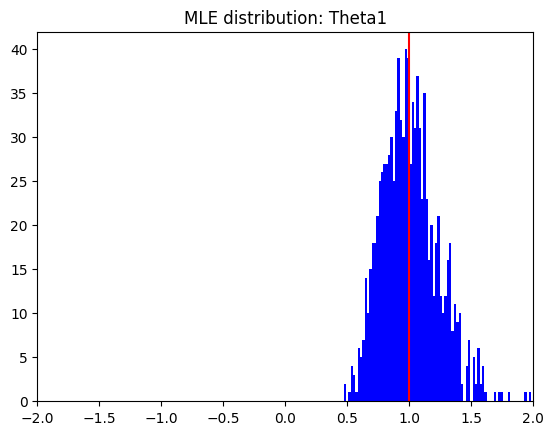

In [80]:
plt.hist(mle0_lst, bins=150, color='b')
plt.xlim(-2,2)
plt.axvline(x=1, color='r')
plt.title('MLE distribution: Theta1')
plt.show()

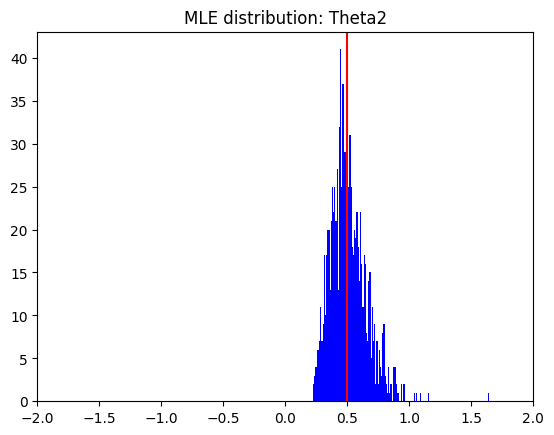

In [81]:
plt.hist(mle1_lst, bins=150, color='b')
plt.xlim(-2, 2)
plt.axvline(x=0.5, color='r')
plt.title('MLE distribution: Theta2')
plt.show()